In [1]:
import os
import sys
import torch
need_pytorch3d=False
try:
    import pytorch3d
except ModuleNotFoundError:
    need_pytorch3d=True
if need_pytorch3d:
    if torch.__version__.startswith("2.1.") and sys.platform.startswith("linux"):
        # We try to install PyTorch3D via a released wheel.
        pyt_version_str=torch.__version__.split("+")[0].replace(".", "")
        version_str="".join([
            f"py3{sys.version_info.minor}_cu",
            torch.version.cuda.replace(".",""),
            f"_pyt{pyt_version_str}"
        ])
        !pip install fvcore iopath
        !pip install --no-index --no-cache-dir pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html
    else:
        # We try to install PyTorch3D from source.
        !pip install 'git+https://github.com/facebookresearch/pytorch3d.git@stable'





     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fvcore: filename=fvcore-0.1.5.post20221221-py3-none-any.whl size=61400 sha256=a5b9c0cc112b337971ac8feb9b5f662f7136b65518b852391083961eef2ef7cf
  Stored in directory: /root/.cache/pip/wheels/01/c0/af/77c1cf53a1be9e42a52b48e5af2169d40ec2e89f7362489dd0
  Created wheel for iopath: filename=iopath-0.1.10-py3-none-any.whl size=31532 sha256=e42349451360d166d8f3dbc5f107be41522f54a2dc2fe58c468e88be238b8ac5
  Stored in directory: /root/.cache/pip/wheels/9a/a3/b6/ac0fcd1b4ed5cfeb3db92e6a0e476cfd48ed0df92b91080c1d
Successfully built fvcore iopath
Looking in links: https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/py310_cu121_pyt210/download.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.3/20.3 MB 155.8 MB/s eta 0:00:00


In [2]:
import os
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from math import radians
from pytorch3d.transforms import axis_angle_to_matrix
# Util function for loading point clouds|
import numpy as np

# Data structures and functions for rendering
from pytorch3d.structures import Pointclouds
from pytorch3d.vis.plotly_vis import AxisArgs, plot_batch_individually, plot_scene
from pytorch3d.renderer import (
    look_at_rotation,
    look_at_view_transform,
    FoVOrthographicCameras,
    PointsRasterizationSettings,
    PointsRenderer,
    PulsarPointsRenderer,
    PointsRasterizer,
    AlphaCompositor,
    NormWeightedCompositor,
    FoVPerspectiveCameras,
    PerspectiveCameras,
    rotate_on_spot,
    OrthographicCameras
)

In [3]:

!pip install open3d

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 399.7/399.7 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 33.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.4/139.4 kB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 25.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 29.1 MB/s eta 0:00:00
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.6
    Uninstalling widgetsnbextension-3.6.6:
      Successfully uninstalled widgetsnbextension-3.6.6
  Attempting uninstall: ipywidgets
    Found existing installation: ipywidgets 7.7.1
    Uninstalling ipywidgets-7.7.1:
      Successfully uninstalled ipywidgets-7.7.1


In [24]:
# Setup

import open3d as o3d
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")



# Load point cloud

pointcloud = o3d.io.read_point_cloud('triceratops.ply')

# Get vertex positions
verts = torch.Tensor(np.asarray(pointcloud.points)).to(device)

# Manually set RGB color (assuming you want to set all points to red)
manual_color = torch.tensor([0.0, 1.0, 0.0], dtype=torch.float32, device=device)

# Repeat the manual color for each vertex
rgb_colors = manual_color.repeat(verts.shape[0], 1)
print(verts.shape[1])

xyz = np.asarray(pointcloud.points)

# Calcola il bounding box
min_xyz = np.min(xyz, axis=0)
max_xyz = np.max(xyz, axis=0)

# Calcola le dimensioni del bounding box
length = max_xyz[0] - min_xyz[0]
width = max_xyz[1] - min_xyz[1]
height = max_xyz[2] - min_xyz[2]
print(length)
print(width)
print(height)
#DOMANI UTILZIZARAE NORMALIZATION PER RENDERE LE IMMAGININE TUTTE UGUALI IN MODO TALE DA VENDERLE
#25k  -> 25
#5k-> 5
#3x4800  (x,y,z)
#bull  lunghezza 1.6   larghezza 1.3  altezza 1.2
#triceratops lungheza 17.6  larghezza 7.7 altezza 5.5   17.6 sta a 20   come 1.6 sta a 5

point_cloud = Pointclouds(points=[verts], features=[rgb_colors])

3
17.668246
7.731463
5.806433


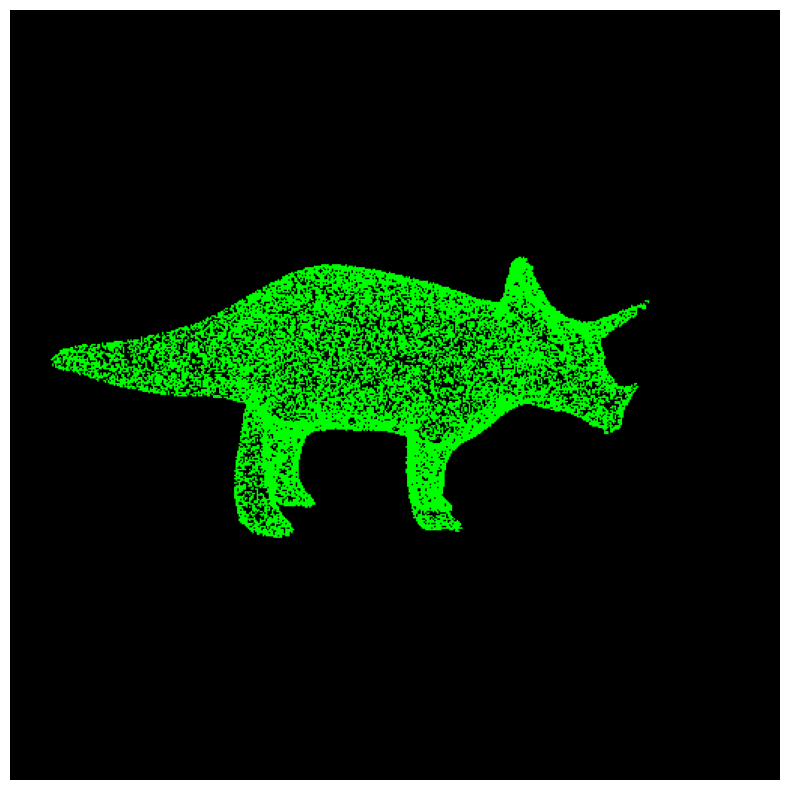

In [25]:
R, T = look_at_view_transform(20, 0, 0)

angles = [radians(0), radians(0),radians(0)]
rotation = axis_angle_to_matrix(torch.FloatTensor(angles))
R, T = rotate_on_spot(R, T, rotation)
cameras = FoVPerspectiveCameras(device=device, R=R, T=T, znear=0.01)#questa la fa di fronte

# Define the settings for rasterization and shading. Here we set the output image to be of size
# 512x512. As we are rendering images for visualization purposes only we will set faces_per_pixel=1
# and blur_radius=0.0. Refer to raster_points.py for explanations of these parameters.
raster_settings = PointsRasterizationSettings(
    image_size=512,
    radius = 0.003,
    points_per_pixel = 10
)
renderer = PointsRenderer(
    rasterizer=PointsRasterizer(cameras=cameras, raster_settings=raster_settings),
    compositor=NormWeightedCompositor()
)


images = renderer(point_cloud)
plt.figure(figsize=(10, 10))
plt.imshow(images[0, ..., :3].cpu().numpy())
plt.axis("off");

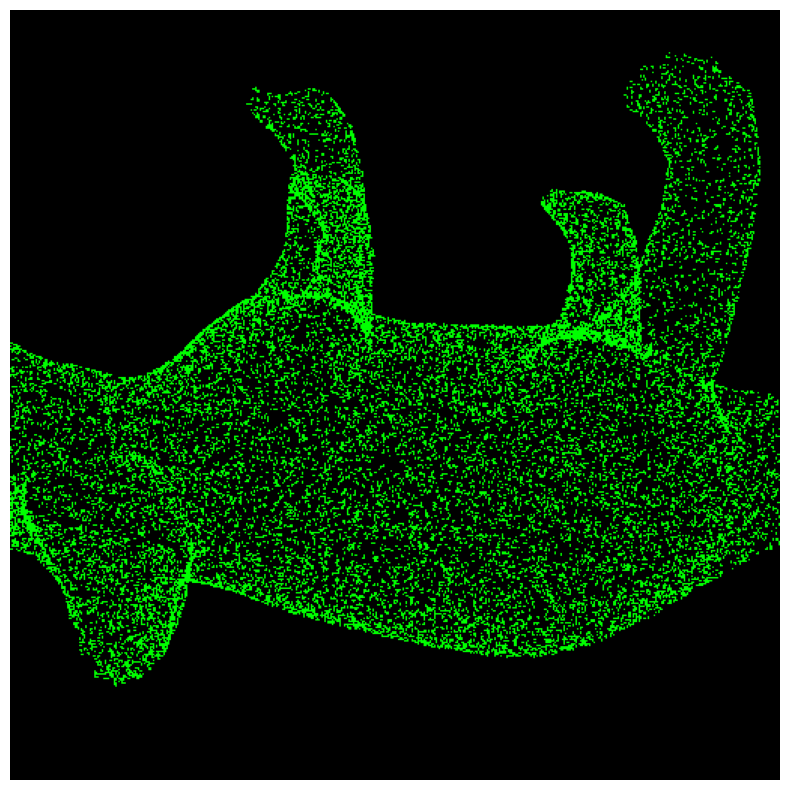

In [6]:
R, T = look_at_view_transform(10, 0, 0)

angles = [radians(0), radians(0),radians(540)]
rotation = axis_angle_to_matrix(torch.FloatTensor(angles))
R, T = rotate_on_spot(R, T, rotation)
cameras = FoVPerspectiveCameras(device=device, R=R, T=T, znear=0.01)#questa la fa di fronte

# Define the settings for rasterization and shading. Here we set the output image to be of size
# 512x512. As we are rendering images for visualization purposes only we will set faces_per_pixel=1
# and blur_radius=0.0. Refer to raster_points.py for explanations of these parameters.
raster_settings = PointsRasterizationSettings(
    image_size=512,
    radius = 0.003,
    points_per_pixel = 10
)
renderer = PointsRenderer(
    rasterizer=PointsRasterizer(cameras=cameras, raster_settings=raster_settings),
    compositor=NormWeightedCompositor()
)


images = renderer(point_cloud)
plt.figure(figsize=(10, 10))
plt.imshow(images[0, ..., :3].cpu().numpy())
plt.axis("off");

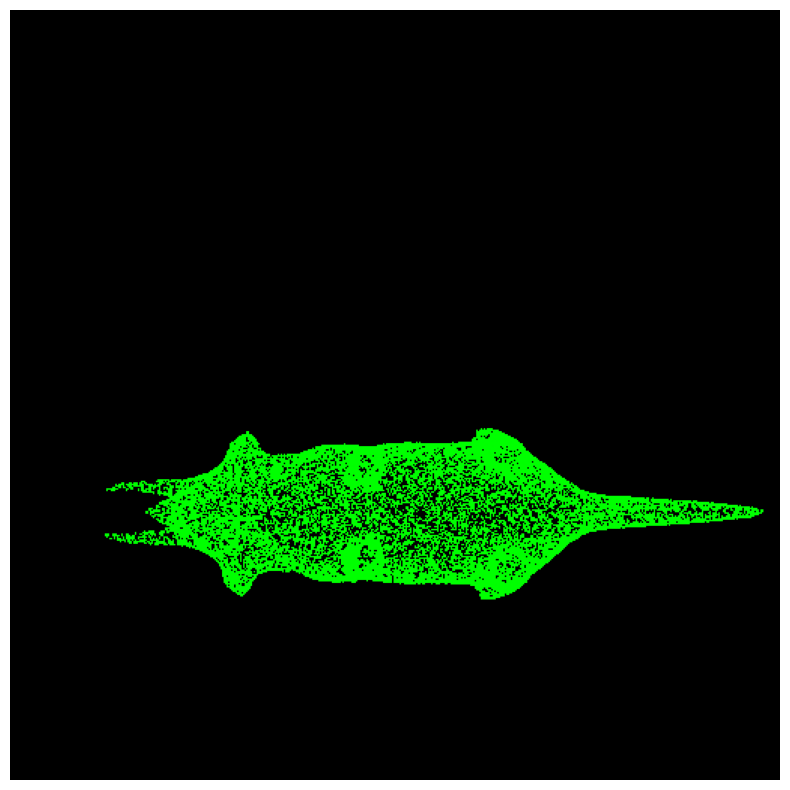

In [14]:
R, T = look_at_view_transform(20,90, 0)
angles = [radians(10), radians(0),radians(0)]
rotation = axis_angle_to_matrix(torch.FloatTensor(angles))
R, T = rotate_on_spot(R, T, rotation)
cameras = FoVPerspectiveCameras(device=device, R=R, T=T, znear=0.01)#questa la fa di fronte

# Define the settings for rasterization and shading. Here we set the output image to be of size
# 512x512. As we are rendering images for visualization purposes only we will set faces_per_pixel=1
# and blur_radius=0.0. Refer to raster_points.py for explanations of these parameters.
raster_settings = PointsRasterizationSettings(
    image_size=512,
    radius = 0.003,
    points_per_pixel = 10
)
renderer = PointsRenderer(
    rasterizer=PointsRasterizer(cameras=cameras, raster_settings=raster_settings),
    compositor=NormWeightedCompositor()
)


images = renderer(point_cloud)
plt.figure(figsize=(10, 10))
plt.imshow(images[0, ..., :3].cpu().numpy())
plt.axis("off");

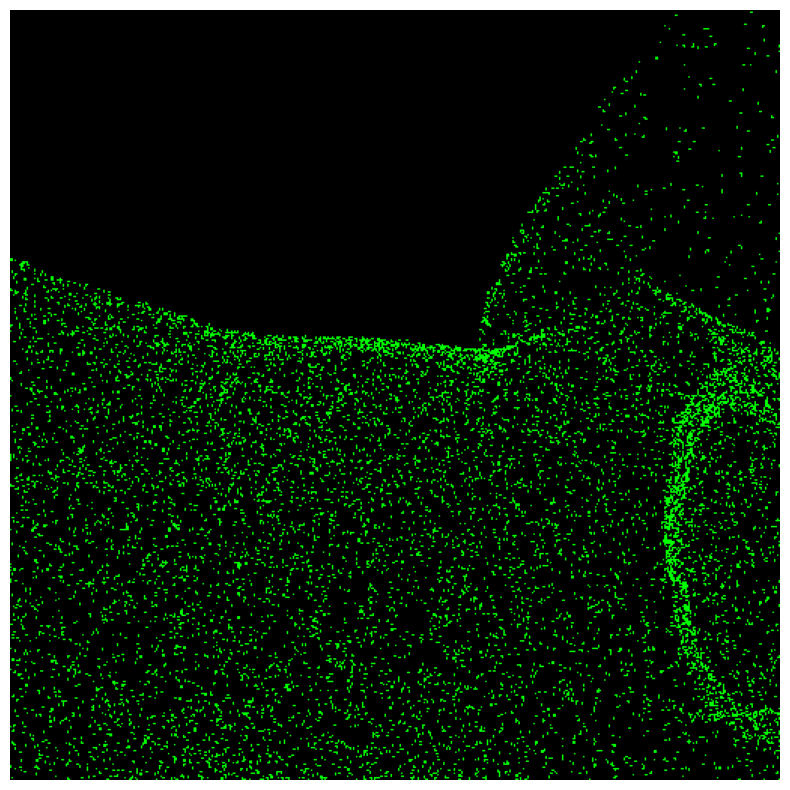

In [8]:
R, T = look_at_view_transform(5, -80, -2)
angles = [radians(15), radians(0),radians(0)]
rotation = axis_angle_to_matrix(torch.FloatTensor(angles))
R, T = rotate_on_spot(R, T, rotation)
cameras = FoVPerspectiveCameras(device=device, R=R, T=T, znear=0.01)#questa la fa di fronte

# Define the settings for rasterization and shading. Here we set the output image to be of size
# 512x512. As we are rendering images for visualization purposes only we will set faces_per_pixel=1
# and blur_radius=0.0. Refer to raster_points.py for explanations of these parameters.
raster_settings = PointsRasterizationSettings(
    image_size=512,
    radius = 0.003,
    points_per_pixel = 10
)
renderer = PointsRenderer(
    rasterizer=PointsRasterizer(cameras=cameras, raster_settings=raster_settings),
    compositor=NormWeightedCompositor()
)


images = renderer(point_cloud)
plt.figure(figsize=(10, 10))
plt.imshow(images[0, ..., :3].cpu().numpy())
plt.axis("off");

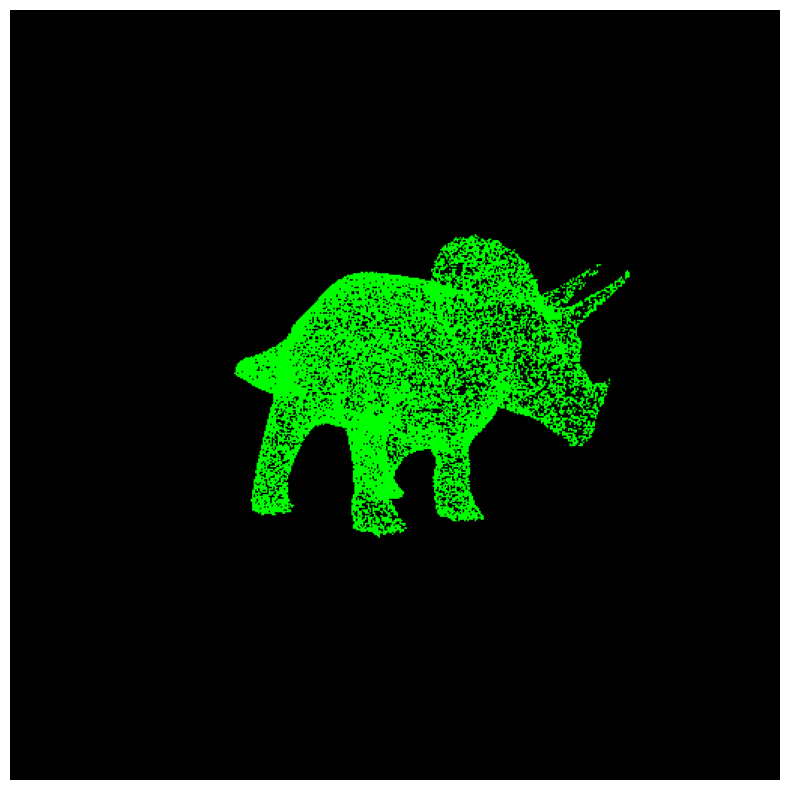

In [17]:
R, T = look_at_view_transform(20, 0, 50)

angles = [radians(0), radians(0),radians(0)]
rotation = axis_angle_to_matrix(torch.FloatTensor(angles))
R, T = rotate_on_spot(R, T, rotation)
cameras = FoVPerspectiveCameras(device=device, R=R, T=T, znear=0.01)#questa la fa di fronte

# Define the settings for rasterization and shading. Here we set the output image to be of size
# 512x512. As we are rendering images for visualization purposes only we will set faces_per_pixel=1
# and blur_radius=0.0. Refer to raster_points.py for explanations of these parameters.
raster_settings = PointsRasterizationSettings(
    image_size=512,
    radius = 0.003,
    points_per_pixel = 10
)
renderer = PointsRenderer(
    rasterizer=PointsRasterizer(cameras=cameras, raster_settings=raster_settings),
    compositor=NormWeightedCompositor()
)


images = renderer(point_cloud)
plt.figure(figsize=(10, 10))
plt.imshow(images[0, ..., :3].cpu().numpy())
plt.axis("off");

In [10]:
!git clone https://github.com/threedle/3DHighlighter.git


Cloning into '3DHighlighter'...
remote: Enumerating objects: 192, done.
remote: Counting objects: 100% (192/192), done.
remote: Compressing objects: 100% (155/155), done.
remote: Total 192 (delta 66), reused 138 (delta 31), pack-reused 0
Receiving objects: 100% (192/192), 19.99 MiB | 32.03 MiB/s, done.
Resolving deltas: 100% (66/66), done.


In [11]:
!pip install --upgrade pip
!pip install torch==1.12.1 torchvision==0.13.1 torchaudio==0.12.1
!pip install matplotlib==3.5.2
!pip install git+https://github.com/openai/CLIP.git
!pip install kaolin==0.15.0 -f https://nvidia-kaolin.s3.us-east-2.amazonaws.com/torch-1.12.1_cu113.html


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 11.7 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 23.1.2
    Uninstalling pip-23.1.2:
      Successfully uninstalled pip-23.1.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━━━━━━ 637.0/776.3 MB 47.7 MB/s eta 0:00:03
ERROR: Operation cancelled by user
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.9/11.9 MB 22.5 MB/s eta 0:00:00
ERROR: Operation cancelled by user
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 3109, in _dep_map
    return self.__dep_map
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 2902, in __getattr__
    raise AttributeError(attr)
AttributeError: _DistInfoDistribution__dep_map

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/base_comm

In [12]:
import os
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Util function for loading point clouds|
import numpy as np

# Data structures and functions for rendering
from pytorch3d.structures import Pointclouds
from pytorch3d.vis.plotly_vis import AxisArgs, plot_batch_individually, plot_scene
from pytorch3d.renderer import (
    look_at_view_transform,
    FoVOrthographicCameras,
    PointsRasterizationSettings,
    PointsRenderer,
    PulsarPointsRenderer,
    PointsRasterizer,
    AlphaCompositor,
    NormWeightedCompositor
)

In [13]:
# Setup
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")

# Set paths
DATA_DIR = "./data"
obj_filename = os.path.join(DATA_DIR, "PittsburghBridge/pointcloud.npz")

# Load point cloud
pointcloud = np.load(obj_filename)
verts = torch.Tensor(pointcloud['verts']).to(device)

rgb = torch.Tensor(pointcloud['rgb']).to(device)

point_cloud = Pointclouds(points=[verts], features=[rgb])

FileNotFoundError: [Errno 2] No such file or directory: './data/PittsburghBridge/pointcloud.npz'

In [ ]:
R, T = look_at_view_transform(20, 10, 0)
cameras = FoVOrthographicCameras(device=device, R=R, T=T, znear=0.01)

# Define the settings for rasterization and shading. Here we set the output image to be of size
# 512x512. As we are rendering images for visualization purposes only we will set faces_per_pixel=1
# and blur_radius=0.0. Refer to rasterize_points.py for explanations of these parameters.
raster_settings = PointsRasterizationSettings(
    image_size=512,
    radius = 0.003,
    points_per_pixel = 10
)

renderer = PulsarPointsRenderer(
    rasterizer=PointsRasterizer(cameras=cameras, raster_settings=raster_settings),
    n_channels=4
).to(device)

images = renderer(point_cloud, gamma=(1e-4,),
                  bg_col=torch.tensor([0.0, 1.0, 0.0, 1.0], dtype=torch.float32, device=device))
plt.figure(figsize=(10, 10))
plt.imshow(images[0, ..., :3].cpu().numpy())
plt.axis("off");

In [ ]:
import sys
import os
import argparse
sys.path.append('/content/3DHighlighter')
from main import optimize # Import the function from the module

class ArgsNamespace:
    def __init__(self, args_dict):
        self.__dict__.update(args_dict)

# Create an instance of ArgsNamespace



# specify the directory you want to iterate over
directory = './dataset/'  # current directory

# iterate over files in the directory

for filename in os.listdir(directory):
    object_name = filename.split('.')[0]
    print(object_name)

    args = ArgsNamespace({
        'seed': 0,
        'obj_path': directory + filename,
        'output_dir': '/content/resultss_' + object_name,
        'object': [object_name],
        'classes': ['shoes'],
        'background': [1., 1., 1.],
        'n_views': 5,
        'frontview_std': 4,
        'frontview_center': [0., 0.],
        'show': False,
        'n_augs': 1,
        'clipavg': 'view',
        'render_res': 224,
        'clipmodel': 'ViT-L/14',
        'jit': False,
        'depth': 5,
        'width': 256,
        'n_classes': 2,
        'positional_encoding': True,
        'sigma': 5.0,
        'learning_rate': 0.0001,
        'n_iter': 2500
    })

    optimize(args)

"""
args = ArgsNamespace({
    'seed': 0,
    'obj_path': '/content/3DHighlighter/data/candle.obj',
    'output_dir': '/content/results_check2',
    'object': ['candle'],
    'classes': ['back'],
    'background': [1., 1., 1.],
    'n_views': 5,
    'frontview_std': 4,
    'frontview_center': [0., 0.],
    'show': False,
    'n_augs': 1,
    'clipavg': 'view',
    'render_res': 224,
    'clipmodel': 'ViT-L/14',
    'jit': False,
    'depth': 4,
    'width': 256,
    'n_classes': 2,
    'positional_encoding': False,
    'sigma': 5.0,
    'learning_rate': 0.00001,
    'n_iter': 500
})

optimize(args)
"""

In [ ]:
from google.colab import files

!zip -r /content/results_television.zip /content/results_television
files.download('/content/results_television.zip')